In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.io.json import json_normalize

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1.1. Portfolio

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


OFFER TYPES: 
- 2 Informational offers - provide no rewards, last either 3 (+social channel) or 4 days (+web channel). 
- 4 BOGO types (difficulty=reward) - 2 lasting for 5 days (one easier - \\$5, one more difficult - \\$10) and 2 lasting for 7 days (one easier - \\$5, one more difficult - \\$10) 
- 4 discounts - 2 lasting for 7 days (one easier - \\$7d / \\$3r, one more difficult - \\$10d / \\$2r) + 2 lasting for 10 days (one easier - \\$10d / \\$2r, one more difficult - \\$20d / \\$5r). Both difficult versions of duration types differ in channels - shorter--> no social, longer--> no social+no mobile). So the longest, the most difficult offer is distributed only via web/email. Difficulty correlates with instancy of channels.

#TODO - maybe add viz of offer_subtypes

In [3]:
# give names to offer types
portfolio['offer_subtype'] = ['bogo_long_difficult', 'bogo_short_difficult', 
                                     'informational_long', 'bogo_long_easy', 
                                     'discount_long_difficult', 'discount_short_easy',
                                     'discount_long_easy', 'informational_short',
                                    'bogo_short_easy', 'discount_short_difficult']

In [4]:
portfolio = portfolio[['id', 'offer_type', 'offer_subtype']]

In [5]:
portfolio

,id,offer_type,offer_subtype
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,bogo_long_difficult
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,bogo_short_difficult
2,3f207df678b143eea3cee63160fa8bed,informational,informational_long
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,bogo_long_easy
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,discount_long_difficult
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,discount_short_easy
6,fafdcd668e3743c1bb461111dcafc2a4,discount,discount_long_easy
7,5a8bc65990b245e5a138643cd4eb9837,informational,informational_short
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,bogo_short_easy
9,2906b810c7d4411798c6938adc9daaa5,discount,discount_short_difficult


## 1.2. Profile

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
if (profile.id.value_counts() > 1).sum() == 0:
    print("profile's ids are all unique")

profile's ids are all unique


In [8]:
print(f"there are {profile.shape[0]} customers in profile")

there are 17000 customers in profile


In [9]:
# renaming 'id' column to 'person' in profile dataset so that we can later merge it with transcript dataset
profile.rename(columns={profile.columns[2]:'person'}, inplace=True)

In [10]:
profile.head()

,gender,age,person,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
#Change type of 'became_member_on' column from int to time:
profile.became_member_on = pd.to_datetime(profile.became_member_on.astype(str), format="%Y/%m/%d")

### Dealing with missing values in Profile

In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
person              17000 non-null object
became_member_on    17000 non-null datetime64[ns]
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


Note: There are missing values in gender, age and income. Age missing values are encoded 118. 

In [13]:
# Missing values in 'gender' column are recorded as NoneType, in 'income' column - as NaNs. 
type(profile.gender[0]), type(profile.income[0])

(NoneType, numpy.float64)

In [14]:
# Replace NoneType with Nans in gender column
profile.gender.fillna(value=np.nan, inplace=True)

In [15]:
#checking the result of transformation
type(profile.gender[0]), type(profile.income[0])

(float, numpy.float64)

In [16]:
# Replace 118 with Nans in age column:
profile.age.replace(118, np.nan, inplace=True)

In [17]:
#reorganize the columns order
profile = profile[['person', 'became_member_on', 'gender', 'age', 'income']]

In [18]:
profile.head()

,person,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55.0,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,F,75.0,100000.0
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,NaN,NaN


## 1.3 Transcript

In [19]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [20]:
transcript.shape

(306534, 4)

In [21]:
print(f"experiment lasted for max {transcript.time.max()/24} days")

experiment lasted for max 29.75 days


Let's see the typical transaction record for one person:

In [22]:
transcript[transcript.person == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


Note: We have many records for one person that are organized chronologically. 'Value' column is currently a json format with either 'offer_id' for offers completed, 'amount' of transactions and 'offer id' for offers received and offers viewed.

In [23]:
# normalize json in value column
value_normalized = json_normalize(transcript['value'])

In [24]:
value_normalized.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [25]:
# merging the two columns 'offer id' and 'offer_id' into new one 'id'
value_normalized['id'] = value_normalized['offer id'].fillna(value_normalized['offer_id'])

In [26]:
# dropping the redundant columns 'offer id', 'offer_id'
value_normalized = value_normalized.drop(['offer id', 'offer_id'], axis=1)

In [27]:
#rename the column 'reward' to 'rewarded'
value_normalized.rename(columns={value_normalized.columns[1]:'rewarded'}, inplace=True)

In [28]:
value_normalized.head()

,amount,rewarded,id
0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [29]:
# join value_normalized with transcript 
transcript_clean = transcript.join(value_normalized)

In [30]:
# dropping 'value', 'event' columns
transcript_clean = transcript_clean.drop(['value'], axis=1)

In [31]:
# reorganize the order of columns
transcript_clean = transcript_clean[['person', 'id', 'event', 'amount', 'rewarded', 'time']]

In [32]:
transcript_clean.head()

,person,id,event,amount,rewarded,time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,NaN,NaN,0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,NaN,NaN,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,offer received,NaN,NaN,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,offer received,NaN,NaN,0
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,offer received,NaN,NaN,0


## Combining datasets

1.1. Merging Profile and Transcript datasets on customer ids:

In [33]:
# checking the number of rows in the datasets
profile.shape, transcript.shape

((17000, 5), (306534, 4))

In [34]:
# because transcipt has more rows, we will do the right join
df = profile.merge(transcript_clean, on='person', how='right')

In [35]:
df.shape

(306534, 10)

1.2. Merging with Portfolio dataset

In [36]:
starbucks = df.merge(portfolio, on='id', how='left')

In [37]:
starbucks.head()

,person,became_member_on,gender,age,income,id,event,amount,rewarded,time,offer_type,offer_subtype
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,offer received,NaN,NaN,168,discount,discount_short_difficult
1,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,offer viewed,NaN,NaN,216,discount,discount_short_difficult
2,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,NaN,NaN,336,discount,discount_long_difficult
3,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer viewed,NaN,NaN,348,discount,discount_long_difficult
4,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,NaN,transaction,0.35,NaN,360,NaN,NaN


In [38]:
starbucks.shape

(306534, 12)

## One-hot encoding

In [39]:
starbucks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 12 columns):
person              306534 non-null object
became_member_on    306534 non-null datetime64[ns]
gender              272762 non-null object
age                 272762 non-null float64
income              272762 non-null float64
id                  167581 non-null object
event               306534 non-null object
amount              138953 non-null float64
rewarded            33579 non-null float64
time                306534 non-null int64
offer_type          167581 non-null object
offer_subtype       167581 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(6)
memory usage: 30.4+ MB


Note: there are few columns that are categorical and need to be reencoded as dummies - event, offer_type, offer_subtype

In [40]:
starbucks_fin = pd.get_dummies(starbucks, columns=['event', 'offer_type', 'offer_subtype'])

In [41]:
starbucks_fin.columns

Index(['person', 'became_member_on', 'gender', 'age', 'income', 'id', 'amount',
       'rewarded', 'time', 'event_offer completed', 'event_offer received',
       'event_offer viewed', 'event_transaction', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational',
       'offer_subtype_bogo_long_difficult', 'offer_subtype_bogo_long_easy',
       'offer_subtype_bogo_short_difficult', 'offer_subtype_bogo_short_easy',
       'offer_subtype_discount_long_difficult',
       'offer_subtype_discount_long_easy',
       'offer_subtype_discount_short_difficult',
       'offer_subtype_discount_short_easy', 'offer_subtype_informational_long',
       'offer_subtype_informational_short'],
      dtype='object')

In [42]:
# reordering the columns
starbucks_fin = starbucks_fin[['person', 'became_member_on', 'age', 'income',
                               'id', 'amount','rewarded', 'time', 
                               'event_offer completed', 'event_offer received', 'event_offer viewed',
                               'event_transaction', 'offer_type_bogo', 'offer_type_discount',
                               'offer_type_informational', 'offer_subtype_bogo_long_difficult',
                               'offer_subtype_bogo_long_easy', 'offer_subtype_bogo_short_difficult',
                               'offer_subtype_bogo_short_easy',
                               'offer_subtype_discount_long_difficult',
                               'offer_subtype_discount_long_easy',
                               'offer_subtype_discount_short_difficult',
                               'offer_subtype_discount_short_easy', 'offer_subtype_informational_long',
                               'offer_subtype_informational_short']]

In [43]:
# renaming the columns
starbucks_fin.columns = ['person', 'became_member_on', 'age', 'income', 
                         'id', 'amount','rewarded', 'time',
                         'offer_completed', 'offer_received', 'offer_viewed',
                         'transaction', 'bogo', 'discount', 'informational', 
                         'bogo_long_difficult', 'bogo_long_easy', 
                         'bogo_short_difficult', 'bogo_short_easy',
                         'discount_long_difficult', 'discount_long_easy',
                         'discount_short_difficult', 'discount_short_easy', 
                         'informational_long', 'informational_short']

In [44]:
starbucks_fin.head()

,person,became_member_on,age,income,id,amount,rewarded,time,offer_completed,offer_received,...,bogo_long_difficult,bogo_long_easy,bogo_short_difficult,bogo_short_easy,discount_long_difficult,discount_long_easy,discount_short_difficult,discount_short_easy,informational_long,informational_short
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,168,0,1,...,0,0,0,0,0,0,1,0,0,0
1,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,216,0,0,...,0,0,0,0,0,0,1,0,0,0
2,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,336,0,1,...,0,0,0,0,1,0,0,0,0,0
3,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,348,0,0,...,0,0,0,0,1,0,0,0,0,0
4,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,0.35,NaN,360,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
starbucks_fin.shape

(306534, 25)

## Aggregation

1.  at person level - total_amount, total_rewarded, offers_received, offers_viewed, offers_completed


In [46]:
aggr_by_person = pd.DataFrame(starbucks_fin.groupby('person')['amount', 'rewarded', 'transaction', 'offer_received', 'offer_viewed', 'offer_completed'].sum()).reset_index()

In [47]:
#rename columns
aggr_by_person.columns = ['person','total_amount', 'total_rewarded', 'transactions_num', 'offers_received', 'offers_viewed', 'offers_completed']

In [48]:
aggr_by_person.head()

,person,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,offers_completed
0,0009655768c64bdeb2e877511632db8f,127.60,9.0,8,5,4,3
1,00116118485d4dfda04fdbaba9a87b5c,4.09,0.0,3,2,2,0
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,13.0,5,5,5,3
3,0020c2b971eb4e9188eac86d93036a77,196.86,14.0,8,5,3,3
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,13.0,12,4,4,3


In [49]:
aggr_by_person.shape

(17000, 7)

2. at personal level - number of offer types 

In [50]:
aggr = aggr_by_person.copy()
for offer_type in ['bogo', 'discount', 'informational']:
    for event in ['offer_received', 'offer_viewed', 'offer_completed']:
        total = pd.DataFrame(starbucks_fin.groupby(['person', offer_type])[event].sum()).reset_index()
        total = total[total[offer_type] == 1]
        total = total.drop(offer_type, axis=1)
        new_col_title = offer_type + '_' + event.split('_')[1]
        total.columns = ['person', new_col_title]
        aggr = aggr.merge(total, on='person', how='left')
        
aggr.drop(['informational_completed'], axis=1, inplace=True)

In [51]:
aggr.head()

,person,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,offers_completed,bogo_received,bogo_viewed,bogo_completed,discount_received,discount_viewed,discount_completed,informational_received,informational_viewed
0,0009655768c64bdeb2e877511632db8f,127.60,9.0,8,5,4,3,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0
1,00116118485d4dfda04fdbaba9a87b5c,4.09,0.0,3,2,2,0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,13.0,5,5,5,3,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
3,0020c2b971eb4e9188eac86d93036a77,196.86,14.0,8,5,3,3,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,13.0,12,4,4,3,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0


Note: NaNs in bogo_received, bogo_viewed, bogo_completed mean that no bogos were received.
the same is true about other offer types.

In [52]:
aggr.shape

(17000, 15)

In [53]:
#merge with demographic info
starbucks_aggr = profile.merge(aggr, on='person')

In [54]:
starbucks_aggr.shape

(17000, 19)

In [55]:
starbucks_aggr.head(10)

,person,became_member_on,gender,age,income,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,offers_completed,bogo_received,bogo_viewed,bogo_completed,discount_received,discount_viewed,discount_completed,informational_received,informational_viewed
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,20.40,5.0,9,5,5,2,NaN,NaN,NaN,5.0,5.0,2.0,NaN,NaN
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55.0,112000.0,77.01,5.0,3,2,0,1,1.0,0.0,1.0,NaN,NaN,NaN,1.0,0.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,NaN,NaN,14.30,0.0,6,2,2,0,1.0,1.0,0.0,NaN,NaN,NaN,1.0,1.0
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,F,75.0,100000.0,159.27,20.0,7,4,4,3,3.0,3.0,3.0,NaN,NaN,NaN,1.0,1.0
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,NaN,NaN,4.65,0.0,3,5,3,0,NaN,NaN,NaN,3.0,2.0,0.0,2.0,1.0
5,e2127556f4f64592b11af22de27a7932,2018-04-26,M,68.0,70000.0,57.73,7.0,3,4,3,2,1.0,1.0,1.0,2.0,2.0,1.0,1.0,0.0
6,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,NaN,NaN,0.00,0.0,0,5,5,0,1.0,1.0,0.0,3.0,3.0,0.0,1.0,1.0
7,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,NaN,NaN,0.24,0.0,2,5,4,0,3.0,2.0,0.0,2.0,2.0,0.0,NaN,NaN
8,389bc3fa690240e798340f5a15918d5c,2018-02-09,M,65.0,53000.0,36.43,19.0,3,6,6,5,4.0,4.0,3.0,2.0,2.0,2.0,NaN,NaN
9,8974fc5686fe429db53ddde067b88302,2016-11-22,NaN,NaN,NaN,15.62,5.0,6,4,3,1,3.0,2.0,1.0,NaN,NaN,NaN,1.0,1.0


3. at personal level - total_bogo, total_discount in \\$

In [56]:
aggr2 = aggr_by_person.copy()[['person']]
for offer_type in ['bogo', 'discount']:
    total = pd.DataFrame(starbucks_fin.groupby(['person', offer_type, 'offer_completed'])['rewarded'].sum()).reset_index()
    total = total[(total[offer_type] == 1) & (total['offer_completed'] == 1)]
    total = total.drop([offer_type, 'offer_completed'], axis=1)
    new_col_title = 'total_'+ offer_type
    total.columns = ['person', new_col_title]
    aggr2 = aggr2.merge(total, on='person', how='left')

In [57]:
aggr2.head()

,person,total_bogo,total_discount
0,0009655768c64bdeb2e877511632db8f,5.0,4.0
1,00116118485d4dfda04fdbaba9a87b5c,NaN,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,5.0,8.0
3,0020c2b971eb4e9188eac86d93036a77,10.0,4.0
4,0020ccbbb6d84e358d3414a3ff76cffd,10.0,3.0


In [58]:
aggr2.shape

(17000, 3)

In [59]:
#merge with demographic info
starbucks_aggr = starbucks_aggr.merge(aggr2, on='person')

In [60]:
starbucks_aggr.head()

,person,became_member_on,gender,age,income,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,...,bogo_received,bogo_viewed,bogo_completed,discount_received,discount_viewed,discount_completed,informational_received,informational_viewed,total_bogo,total_discount
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,20.40,5.0,9,5,5,...,NaN,NaN,NaN,5.0,5.0,2.0,NaN,NaN,NaN,5.0
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55.0,112000.0,77.01,5.0,3,2,0,...,1.0,0.0,1.0,NaN,NaN,NaN,1.0,0.0,5.0,NaN
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,NaN,NaN,14.30,0.0,6,2,2,...,1.0,1.0,0.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,F,75.0,100000.0,159.27,20.0,7,4,4,...,3.0,3.0,3.0,NaN,NaN,NaN,1.0,1.0,20.0,NaN
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,NaN,NaN,4.65,0.0,3,5,3,...,NaN,NaN,NaN,3.0,2.0,0.0,2.0,1.0,NaN,NaN


## Feature Engineering

In [61]:
starbucks_aggr['avg_order_size'] = round(starbucks_aggr['total_amount']/starbucks_aggr['transactions_num'], 2)

In [62]:
starbucks_aggr['avg_reward_size'] = round(starbucks_aggr['total_rewarded']/starbucks_aggr['offers_completed'], 2)

In [63]:
# average bogo size and average discount size
for each in ['bogo', 'discount']:
    starbucks_aggr['avg_'+each+'_size'] = round(starbucks_aggr['total_'+each]/starbucks_aggr[each+'_completed'], 2)

In [64]:
for each in ['offers', 'bogo', 'discount', 'informational']:
    # reponse rate, % offers viewed to offers received (note: no div by 0 because NaNs)
    starbucks_aggr[each+'_rr'] = round(starbucks_aggr[each+'_viewed']/starbucks_aggr[each+'_received'] * 100, 2)
    # conversion rate, % offers completed to offers viewed
    if each != 'informational':
        starbucks_aggr[each+'_cvr'] = round(starbucks_aggr[each+'_completed']/starbucks_aggr[each+'_viewed'] * 100, 2)
        # replace div by 0 - if no offers viewed, than cvr = 0
        starbucks_aggr[each+'_cvr'] = starbucks_aggr[each+'_cvr'].replace(np.inf, 0)

In [65]:
starbucks_aggr.head()

,person,became_member_on,gender,age,income,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,...,avg_reward_size,avg_bogo_size,avg_discount_size,offers_rr,offers_cvr,bogo_rr,bogo_cvr,discount_rr,discount_cvr,informational_rr
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,20.40,5.0,9,5,5,...,2.50,NaN,2.5,100.0,40.0,NaN,NaN,100.00,40.0,NaN
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55.0,112000.0,77.01,5.0,3,2,0,...,5.00,5.00,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,NaN,NaN,14.30,0.0,6,2,2,...,NaN,NaN,NaN,100.0,0.0,100.0,0.0,NaN,NaN,100.0
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,F,75.0,100000.0,159.27,20.0,7,4,4,...,6.67,6.67,NaN,100.0,75.0,100.0,100.0,NaN,NaN,100.0
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,NaN,NaN,4.65,0.0,3,5,3,...,NaN,NaN,NaN,60.0,0.0,NaN,NaN,66.67,0.0,50.0


In [66]:
#calculate membership days relative to the most recent member in the dataset
starbucks_aggr['membership_days'] = starbucks_aggr.became_member_on.max()-starbucks_aggr.became_member_on
starbucks_aggr['membership_days'] = starbucks_aggr['membership_days'].apply(lambda x: x.days)

In [67]:
#drop original membership column
starbucks_aggr.drop('became_member_on', axis=1, inplace=True)

In [68]:
# create new column with income binned into quartiles
bins = pd.qcut(starbucks_aggr.income, 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])  #qcut -> bins into quartiles if 4 or quantiles if 10
starbucks_aggr.income.groupby(bins).agg(['count', 'min', 'max'])

,count,min,max
income,,,
Q1,3781,30000.0,49000.0
Q2,3863,50000.0,64000.0
Q3,3616,65000.0,80000.0
Q4,3565,81000.0,120000.0


In [69]:
bins2 = [30000, 50000, 65000, 81000, 120000]
labels = ['low_income','middle_low_income', 'middle_high_income', 'high_income']
starbucks_aggr['income_binned'] = pd.cut(starbucks_aggr['income'], bins2, labels=labels)
starbucks_aggr[['income','income_binned']].head(10)

,income,income_binned
0,NaN,NaN
1,112000.0,high_income
2,NaN,NaN
3,100000.0,high_income
4,NaN,NaN
5,70000.0,middle_high_income
6,NaN,NaN
7,NaN,NaN
8,53000.0,middle_low_income
9,NaN,NaN


In [70]:
bins = pd.qcut(starbucks_aggr.age, 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])  #qcut -> bins into quartiles
starbucks_aggr.age.groupby(bins).agg(['count', 'min', 'max'])

,count,min,max
age,,,
Q1,3718,18.0,42.0
Q2,3770,43.0,55.0
Q3,3635,56.0,66.0
Q4,3702,67.0,101.0


In [71]:
# create new column with age binned
bins_age = [18, 43, 56, 67, 110]
labels = ['young', 'middle-aged', 'senior', 'old']
starbucks_aggr['age_binned'] = pd.cut(starbucks_aggr.age, bins_age, labels=labels)
starbucks_aggr[['age','age_binned']].head(10)

,age,age_binned
0,NaN,NaN
1,55.0,middle-aged
2,NaN,NaN
3,75.0,old
4,NaN,NaN
5,68.0,old
6,NaN,NaN
7,NaN,NaN
8,65.0,senior
9,NaN,NaN


In [72]:
#reorder columns
starbucks_aggr = starbucks_aggr[['person', 'membership_days', 'gender', 'age', 'age_binned', 'income', 'income_binned', 'total_amount', 'total_rewarded',
       'transactions_num', 'offers_received', 'offers_viewed',
       'offers_completed', 'bogo_received', 'bogo_viewed', 'bogo_completed',
       'discount_received', 'discount_viewed', 'discount_completed',
       'informational_received', 'informational_viewed', 'total_bogo',
       'total_discount', 'avg_order_size', 'avg_reward_size', 'avg_bogo_size',
       'avg_discount_size', 'offers_rr', 'offers_cvr', 'bogo_rr', 'bogo_cvr',
       'discount_rr', 'discount_cvr', 'informational_rr']]

In [73]:
starbucks_aggr.head()

,person,membership_days,gender,age,age_binned,income,income_binned,total_amount,total_rewarded,transactions_num,...,avg_reward_size,avg_bogo_size,avg_discount_size,offers_rr,offers_cvr,bogo_rr,bogo_cvr,discount_rr,discount_cvr,informational_rr
0,68be06ca386d4c31939f3a4f0e3dd783,529,NaN,NaN,NaN,NaN,NaN,20.40,5.0,9,...,2.50,NaN,2.5,100.0,40.0,NaN,NaN,100.00,40.0,NaN
1,0610b486422d4921ae7d2bf64640c50b,376,F,55.0,middle-aged,112000.0,high_income,77.01,5.0,3,...,5.00,5.00,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0
2,38fe809add3b4fcf9315a9694bb96ff5,14,NaN,NaN,NaN,NaN,NaN,14.30,0.0,6,...,NaN,NaN,NaN,100.0,0.0,100.0,0.0,NaN,NaN,100.0
3,78afa995795e4d85b5d9ceeca43f5fef,443,F,75.0,old,100000.0,high_income,159.27,20.0,7,...,6.67,6.67,NaN,100.0,75.0,100.0,100.0,NaN,NaN,100.0
4,a03223e636434f42ac4c3df47e8bac43,356,NaN,NaN,NaN,NaN,NaN,4.65,0.0,3,...,NaN,NaN,NaN,60.0,0.0,NaN,NaN,66.67,0.0,50.0


In [74]:
starbucks_aggr.shape

(17000, 34)

## EDA

In [75]:
starbucks_aggr.describe().T

,count,mean,std,min,25%,50%,75%,max
membership_days,17000.0,517.449882,411.223904,0.00,208.00,358.000,791.0000,1823.00
age,14825.0,54.393524,17.383705,18.00,42.00,55.000,66.0000,101.00
income,14825.0,65404.991568,21598.299410,30000.00,49000.00,64000.000,80000.0000,120000.00
total_amount,17000.0,104.438351,125.922619,0.00,21.82,69.405,148.7825,1608.69
total_rewarded,17000.0,9.686824,9.243217,0.00,2.00,7.000,15.0000,55.00
transactions_num,17000.0,8.173706,5.116250,0.00,4.00,7.000,11.0000,36.00
offers_received,17000.0,4.486882,1.076165,0.00,4.00,5.000,5.0000,6.00
offers_viewed,17000.0,3.395588,1.297653,0.00,2.75,3.000,4.0000,6.00
offers_completed,17000.0,1.975235,1.605563,0.00,1.00,2.000,3.0000,6.00
bogo_received,14992.0,2.034352,0.966841,1.00,1.00,2.000,3.0000,6.00


**Note:** 
 - **Customers**: the typical Stabucks mobile app customer is middle-aged (median - 55 years), has middle-high income (median - \\$64000) and has been a member for about a year (median - 358 days). During the experiment, the customers spent on average \\$104.44 (min - \\$0, max - \\$1608.7) and got \\$9.68 (min - \\$0, max - \\$55) rewarded. Furthermore, customers would make on average 8 transactions with the average order size being \\$13.65.
 
 
 - **Offers**: Customers would receive on average 4-5 offers, would view about 3 offers and would complete about 2 offers. The average return on bogo offers is higher than on discount offers - \\$12 vs $5. Each customer viewed on average 76% of offers he/she received (Response Rate), with bogo offers being viewed more often (83%) than discounts (70%) or informational offers (71%). Each customer reacted upon (CVR) about 61% of offers he/she viewed, with CVR for discounts being higher (76.5%) than for bogo (60%). It should be noted, however, that the actual CVR per customer should be lower because as it is now it also includes customers that didn't interact with the offer, but got rewarded.


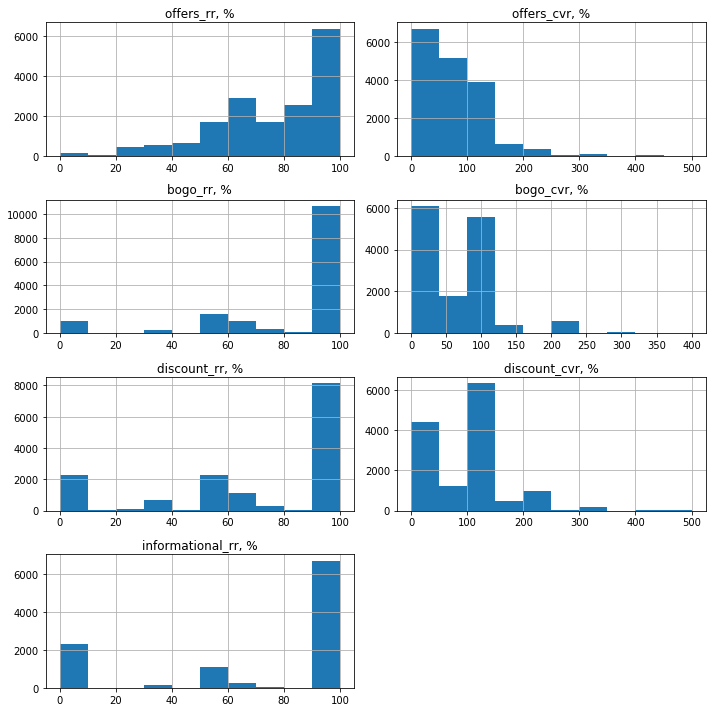

In [76]:
# if cvr > 100, it means more offers completed than offers viewed - waste of money
cols = ['offers_rr', 'offers_cvr','bogo_rr', 'bogo_cvr', 'discount_rr', 'discount_cvr','informational_rr']
plt.figure(figsize=(10, 10));

for i, each in enumerate(starbucks_aggr[cols]):
    plt.subplot(4,2,i+1)
    starbucks_aggr[each].hist();
    plt.title(f"{each}, %");
    plt.tight_layout();

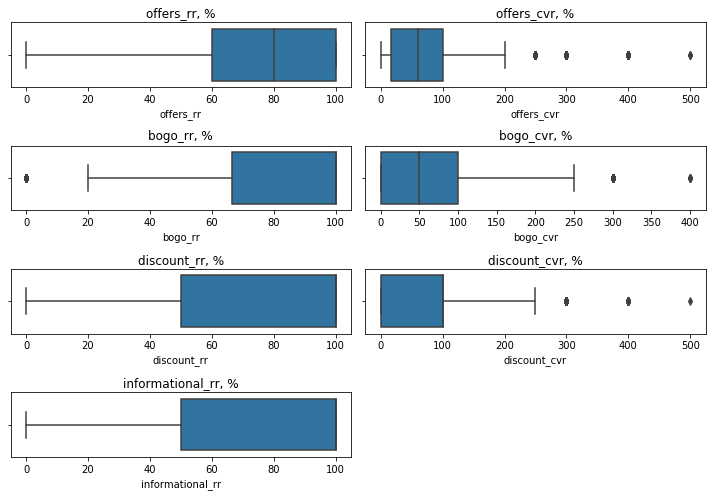

In [77]:
# if cvr > 100, it means more offers completed than offers viewed - waste of money
cols = ['offers_rr', 'offers_cvr','bogo_rr', 'bogo_cvr', 'discount_rr', 'discount_cvr','informational_rr']
plt.figure(figsize=(10, 7));

for i, each in enumerate(starbucks_aggr[cols]):
    plt.subplot(4,2,i+1)
    sns.boxplot(starbucks_aggr[each]);
    plt.title(f"{each}, %");
    plt.tight_layout();

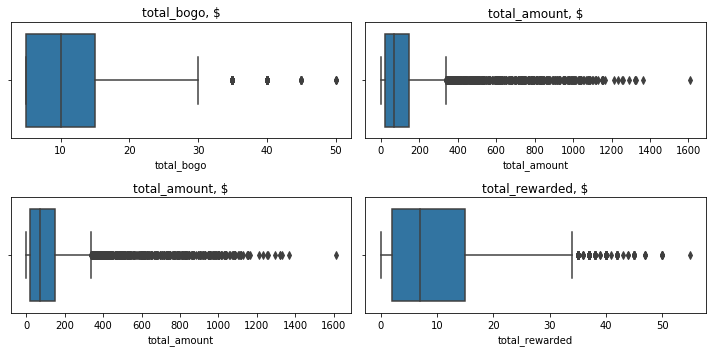

In [78]:
plt.figure(figsize=(10, 5));

for i, each in enumerate(starbucks_aggr[['total_bogo', 'total_amount', 'total_amount', 'total_rewarded']]):
    plt.subplot(2,2,i+1)
    sns.boxplot(starbucks_aggr[each]);
    plt.title(f"{each}, $");
    plt.tight_layout();

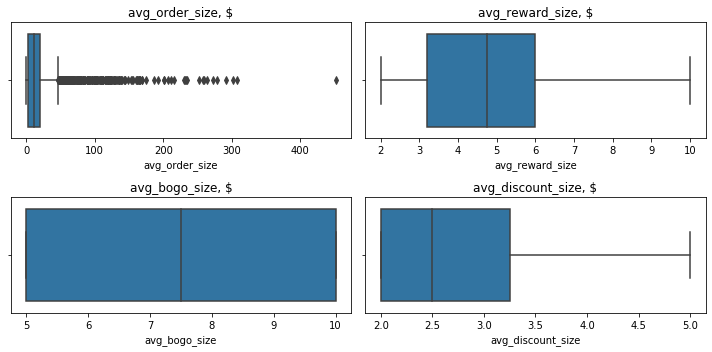

In [79]:
plt.figure(figsize=(10, 5));

for i, each in enumerate(starbucks_aggr[['avg_order_size', 'avg_reward_size','avg_bogo_size', 'avg_discount_size']]):
    plt.subplot(2,2,i+1)
    sns.boxplot(starbucks_aggr[each]);
    plt.title(f"{each}, $");
    plt.tight_layout();

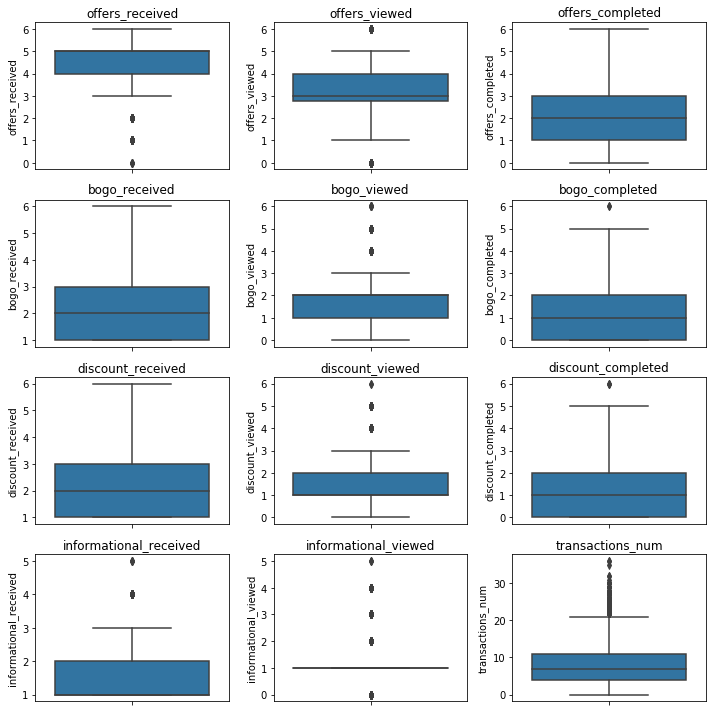

In [80]:
cols = ['offers_received','offers_viewed', 'offers_completed', 
        'bogo_received', 'bogo_viewed','bogo_completed', 
        'discount_received', 'discount_viewed','discount_completed', 
        'informational_received', 'informational_viewed', 'transactions_num']
    
plt.figure(figsize=(10, 10));

for i, each in enumerate(starbucks_aggr[cols]):
    plt.subplot(4,3,i+1)
    sns.boxplot(y=starbucks_aggr[each]);
    plt.title(f"{each}");
    plt.tight_layout();

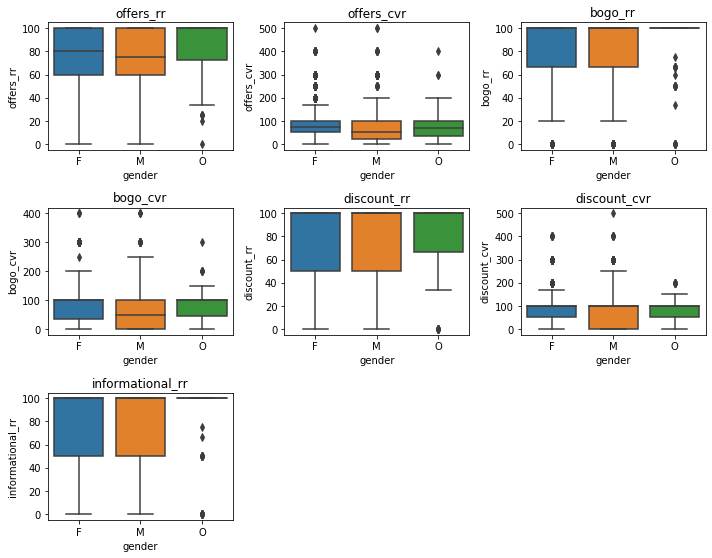

In [81]:
cols = ['offers_rr', 'offers_cvr','bogo_rr', 'bogo_cvr','discount_rr', 'discount_cvr','informational_rr']


plt.figure(figsize=(10, 10));

for i, each in enumerate(starbucks_aggr[cols]):
    plt.subplot(4,3,i+1)
    sns.boxplot(y=each, x='gender', data=starbucks_aggr);
    plt.title(f"{each}");
    plt.tight_layout();

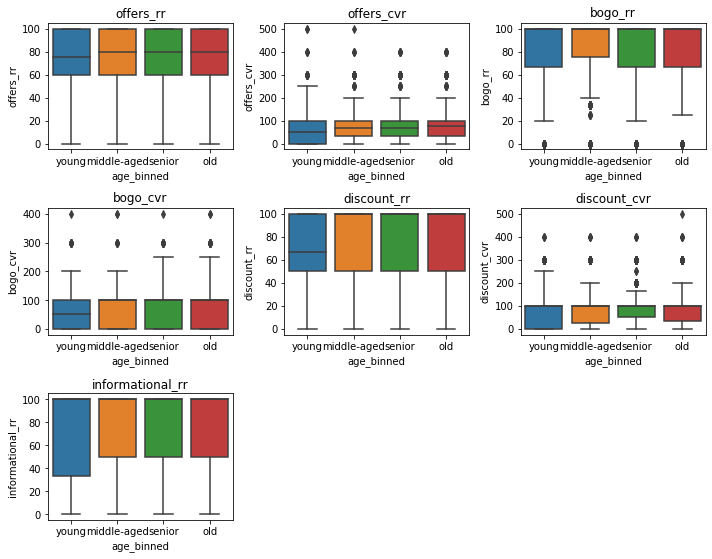

In [82]:
cols = ['offers_rr', 'offers_cvr','bogo_rr', 'bogo_cvr','discount_rr', 'discount_cvr','informational_rr']


plt.figure(figsize=(10, 10));

for i, each in enumerate(starbucks_aggr[cols]):
    plt.subplot(4,3,i+1)
    sns.boxplot(y=each, x='age_binned', data=starbucks_aggr);
    plt.title(f"{each}");
    plt.tight_layout();

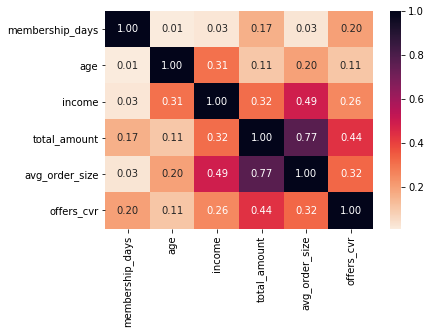

In [83]:
cols = ['membership_days', 'age', 'income', 'total_amount', 'avg_order_size', 'offers_cvr']
sns.heatmap(starbucks_aggr[cols].corr(), cmap = 'rocket_r', annot = True, fmt = '.2f');

## Metrics

Promotional Effectiveness Metrics & Email Capture Benchmarks Across 10 Ecommerce Industries [2019 Report], https://www.bigcommerce.com/blog/promotional-marketing/#what-is-promotional-marketing

In [84]:
print(f"{(starbucks_aggr.offers_received != 0).sum()} customers received offers, while {(starbucks_aggr.offers_received == 0).sum()} did not")

16994 customers received offers, while 6 did not


In [85]:
print(f"Out of those who received, {((starbucks_aggr.offers_received != 0) & (starbucks_aggr.offers_viewed != 0)).sum()} customers viewed offers, while {((starbucks_aggr.offers_received != 0) & (starbucks_aggr.offers_viewed == 0)).sum()} did not")

Out of those who received, 16834 customers viewed offers, while 160 did not


In [86]:
print(f"Out of those who received & viewed, {((starbucks_aggr.offers_received != 0) & (starbucks_aggr.offers_viewed != 0) & (starbucks_aggr.offers_completed != 0)).sum()} customers completed the offers, while {((starbucks_aggr.offers_received != 0) & (starbucks_aggr.offers_viewed != 0) & (starbucks_aggr.offers_completed == 0)).sum()} did not")

Out of those who received & viewed, 12701 customers completed the offers, while 4133 did not


 ### Viewing Rate

In [87]:
# total viewing rate - % customers who viewed the offers
viewing_rate = (starbucks_aggr.offers_viewed > 0).sum()
round(viewing_rate/starbucks_aggr.shape[0]*100, 2)

99.02

### Rewarded Rate

In [88]:
# total rewarded rate - % customers who completed the offers 
rewarded_rate = (starbucks_aggr.offers_completed > 0).sum()
print(f"rewarded rate is {rewarded_rate/starbucks_aggr.shape[0]*100:.2f}%. Right now this number also includes customers that did not interact with the offers but got rewarded.")

rewarded rate is 75.14%. Right now this number also includes customers that did not interact with the offers but got rewarded.


Let's find misattributed customers who should not have been rewarded (those that did not interact with offers but completed offers) and calculate the waisted sum. I do it in two steps:
- first, I find those that did not interact with any of the offers and still got rewarded; 
- second, I find those that got more offers completed than they actually viewed.

**not engaged Conversion rate (CVR)** - % who DID NOT interact with the offers and still got rewarded.

In [89]:
no_views_cvr = starbucks_aggr[(starbucks_aggr.offers_viewed == 0) & (starbucks_aggr.offers_completed > 0)]
cvr_noviews_num = no_views_cvr.shape[0]
cvr_noviews_bogo_total = (no_views_cvr.bogo_received * no_views_cvr.avg_bogo_size).sum()
cvg_noviews_discount_total = (no_views_cvr.discount_received * no_views_cvr.avg_discount_size).sum()
cvr_noviews_total = cvr_noviews_bogo_total + cvg_noviews_discount_total

print(f"there are {round(cvr_noviews_num/starbucks_aggr.shape[0]*100, 2)}% of customers who did not interact with the offers, but still got rewarded in total of ${cvr_noviews_total}")
print(f"Starbucks could have saved ${cvr_noviews_bogo_total} on bogos and ${cvg_noviews_discount_total} on discounts")

there are 0.43% of customers who did not interact with the offers, but still got rewarded in total of $718.0
Starbucks could have saved $362.5 on bogos and $355.5 on discounts


**bad CVR** - more offers completed than viewed

In [90]:
morethanviewed_cvr = starbucks_aggr[starbucks_aggr.offers_cvr > 100]
cvr_morethanviewed_num = morethanviewed_cvr.shape[0]

#calculating the overpaid amount - num incorrectly attributed offers (bogo or discount) * average offer size
bogo_overpaid = (morethanviewed_cvr.bogo_received - morethanviewed_cvr.bogo_viewed)*morethanviewed_cvr.avg_bogo_size
bogo_overpaid_total = bogo_overpaid.sum()
discount_overpaid = (morethanviewed_cvr.discount_received - morethanviewed_cvr.discount_viewed)*morethanviewed_cvr.avg_discount_size
discount_overpaid_total = discount_overpaid.sum()
morethanviewed_cvr_amount = bogo_overpaid_total + discount_overpaid_total

print(f"there are {round(cvr_morethanviewed_num/starbucks_aggr.shape[0]*100, 2)}% who got more offers completed than actually viewed")
print(f"This means that these customers made transactions regardless of offers they received and thus Starbucks overpaid about ${morethanviewed_cvr_amount} or {morethanviewed_cvr_amount/starbucks_aggr.total_rewarded.sum()*100:.2f}% of its total marketing cost")
print(f"More specifically, Starbucks could have saved on bogos: ${bogo_overpaid_total} and on discounts: ${discount_overpaid_total: .2f}")

there are 11.44% who got more offers completed than actually viewed
This means that these customers made transactions regardless of offers they received and thus Starbucks overpaid about $15515.01 or 9.42% of its total marketing cost
More specifically, Starbucks could have saved on bogos: $8444.45 and on discounts: $ 7070.56


**Note:** About 12% of all customers completed offers even though they did not interact with them. As a result, about \\$16233 or almost 10% of the marketing cost got waisted.

Only correctly secured campaigns should be a source of relevant data. 

In [91]:
# TODO: maybe replace those with cvr>100 with cvr=100 
# --> replace bogo_completed with bogo_viewed + discount_completed with discount_viewed

**Engaged conversion rate (CVR)** - number of those who interacted with the offers and got rewarded.

In [92]:
engaged_cvr = ((starbucks_aggr.offers_received != 0) & (starbucks_aggr.offers_viewed > 0) & (starbucks_aggr.offers_completed > 0)).sum()
print(f"there are {round(engaged_cvr/starbucks_aggr.shape[0]*100, 2)}% of customers received and viewed the offers and got rewarded in total of ${starbucks_aggr[((starbucks_aggr.offers_received != 0) & (starbucks_aggr.offers_viewed > 0) & (starbucks_aggr.offers_completed > 0))].total_rewarded.sum()}")

there are 74.71% of customers received and viewed the offers and got rewarded in total of $164137.0


## Predict engaged CVR

In [93]:
starbucks_engaged = starbucks_aggr.copy().iloc[:, 1:11]

In [94]:
starbucks_engaged.head()

,membership_days,gender,age,age_binned,income,income_binned,total_amount,total_rewarded,transactions_num,offers_received
0,529,NaN,NaN,NaN,NaN,NaN,20.40,5.0,9,5
1,376,F,55.0,middle-aged,112000.0,high_income,77.01,5.0,3,2
2,14,NaN,NaN,NaN,NaN,NaN,14.30,0.0,6,2
3,443,F,75.0,old,100000.0,high_income,159.27,20.0,7,4
4,356,NaN,NaN,NaN,NaN,NaN,4.65,0.0,3,5


In [95]:
# create a column 'conversion' => 1 if received & viewed & completed, 0 if not
starbucks_engaged['conversion'] = ((starbucks_aggr.offers_received != 0) & (starbucks_aggr.offers_viewed > 0) & (starbucks_aggr.offers_completed > 0))
starbucks_engaged['conversion'] = starbucks_engaged['conversion'].apply(lambda x: 1 if x == True else 0)

In [96]:
starbucks_engaged.head()

,membership_days,gender,age,age_binned,income,income_binned,total_amount,total_rewarded,transactions_num,offers_received,conversion
0,529,NaN,NaN,NaN,NaN,NaN,20.40,5.0,9,5,1
1,376,F,55.0,middle-aged,112000.0,high_income,77.01,5.0,3,2,0
2,14,NaN,NaN,NaN,NaN,NaN,14.30,0.0,6,2,0
3,443,F,75.0,old,100000.0,high_income,159.27,20.0,7,4,1
4,356,NaN,NaN,NaN,NaN,NaN,4.65,0.0,3,5,0


https://www.themailshark.com/resources/guides/how-to-track-measure-direct-mail/
https://nscpolteksby.ac.id/ebook/files/Ebook/Business%20Administration/Marketing%20Metrics%20(2006)/10.%20Chapter%208%20-%20PROMOTION.pdf

Revenue 

In [97]:
revenue = starbucks_aggr.total_amount.sum()
revenue

1775451.9699999997

Campaign cost

In [98]:
campaign_cost = starbucks_aggr.total_rewarded.sum()
campaign_cost

164676.0

Cost per Acquisition (CPA) -  "also known as cost per order or lead – tells you how much each new customer cost to obtain."

In [99]:
# campaign cost per transaction
cost_per_acquisition = campaign_cost/starbucks_aggr.transactions_num.sum()
cost_per_acquisition

1.1851201485394343

Average Order Size 

In [100]:
# revenue per transaction
average_order_size = revenue/starbucks_aggr.transactions_num.sum()
average_order_size

12.777356156398204

Revenue per Order - how much profit you made from each order on average

In [101]:
revenue_per_order = average_order_size-cost_per_acquisition
revenue_per_order

11.59223600785877

Return on Investment (ROI), %

In [102]:
roi = (revenue-campaign_cost)/campaign_cost * 100
roi

978.1485887439576

# Data Preprocessing

### Dealing with Missing values

In [103]:
# checking how many missing values are in gender and age columns
starbucks_aggr.gender.isna().sum(), starbucks_aggr.age.isna().sum(), starbucks_aggr.income.isna().sum()

(2175, 2175, 2175)

In [104]:
# checking if missing values are in both columns
assert starbucks_aggr[(starbucks_aggr.gender.isna()) & (starbucks_aggr.age.isna()) & (starbucks_aggr.income.isna())].shape[0] == starbucks_aggr.gender.isna().sum()
print(f"there are {starbucks_aggr.gender.isna().sum()} customers that have missing values in gender, age and income columns")

there are 2175 customers that have missing values in gender, age and income columns


In [105]:
starbucks_aggr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17000 entries, 0 to 16999
Data columns (total 34 columns):
person                    17000 non-null object
membership_days           17000 non-null int64
gender                    14825 non-null object
age                       14825 non-null float64
age_binned                14755 non-null category
income                    14825 non-null float64
income_binned             14737 non-null category
total_amount              17000 non-null float64
total_rewarded            17000 non-null float64
transactions_num          17000 non-null uint8
offers_received           17000 non-null uint8
offers_viewed             17000 non-null uint8
offers_completed          17000 non-null uint8
bogo_received             14992 non-null float64
bogo_viewed               14992 non-null float64
bogo_completed            14992 non-null float64
discount_received         14945 non-null float64
discount_viewed           14945 non-null float64
discount_completed 

Impute missing values with median values (to avoid impact of outliers if we took mean values + most_frequent values are usually used for ordinal data, our data is ratio.

In [106]:
starbucks_imputed = starbucks_aggr.copy()

imputer = SimpleImputer(strategy='median')
imputed = imputer.fit_transform(starbucks_aggr[['age', 'income']])

starbucks_imputed[['age', 'income']] = pd.DataFrame(imputed, columns=['age', 'income'])

#checking results of imputation for age and income columns
starbucks_imputed[starbucks_aggr.gender.isna()][['age','income']].head(1)

,age,income
0,55.0,64000.0


Impute missing values for categorical data - gender, age_binned, income_binned - with most frequent data:

In [107]:
values = {'gender': starbucks_aggr.gender.mode()[0], 'age_binned': starbucks_aggr.age_binned.mode()[0], 'income_binned': starbucks_aggr.income_binned.mode()[0]}
starbucks_imputed.fillna(value=values, inplace=True)

In [108]:
#checking results of imputation of categorical data
starbucks_imputed[starbucks_aggr.gender.isna()][['gender','age_binned', 'income_binned']].head(1)

,gender,age_binned,income_binned
0,M,middle-aged,low_income


Replace NaNs with 0s for these columns:
- not all customers received particular offer type. These were filled with NaNs when columns 'bogo_received', 'discount_received' or 'infromational_received' were created. Then the missing values were propagated to 'bogo_viewed', discount_viewed', 'informational_viewed' and to 'bogo_completed', 'discount_completed' columns.
- if no discount or no bogo were completed, then 'total_bogo', 'total_discount', 'avg_bogo_size', 'avg_discount_size' could be calculated and were filled with NaNs.
- if customer made no transactions or had no offers completed, then columns 'avg_order_size' and 'avg_reward_size' were filled with NaNs.
- if customer didn't view any offers, then these produced NaNs for all CVR columns (div by 'viewed' metrics)
- if customer didn't receive particular offer type, then these produced NaNs in all response rate columns  (div by 'received' metrics)

In [109]:
cols = ['bogo_received', 'bogo_viewed', 'bogo_completed', 
        'discount_received', 'discount_viewed', 'discount_completed', 
        'informational_received', 'informational_viewed',
        'total_bogo', 'total_discount', 'avg_bogo_size', 'avg_discount_size',
        'avg_order_size', 'avg_reward_size',
        'offers_rr', 'offers_cvr', 'bogo_rr', 'bogo_cvr', 'discount_rr', 'discount_cvr','informational_rr']

starbucks_imputed[cols] = starbucks_imputed[cols].replace(np.nan, 0)

In [110]:
starbucks_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17000 entries, 0 to 16999
Data columns (total 34 columns):
person                    17000 non-null object
membership_days           17000 non-null int64
gender                    17000 non-null object
age                       17000 non-null float64
age_binned                17000 non-null category
income                    17000 non-null float64
income_binned             17000 non-null category
total_amount              17000 non-null float64
total_rewarded            17000 non-null float64
transactions_num          17000 non-null uint8
offers_received           17000 non-null uint8
offers_viewed             17000 non-null uint8
offers_completed          17000 non-null uint8
bogo_received             17000 non-null float64
bogo_viewed               17000 non-null float64
bogo_completed            17000 non-null float64
discount_received         17000 non-null float64
discount_viewed           17000 non-null float64
discount_completed 

### One-Hot Encoding categorical data

In [111]:
categorical_col = starbucks_imputed.columns[(starbucks_imputed.dtypes == 'category') | (starbucks_imputed.dtypes == 'object')]
categorical_col

Index(['person', 'gender', 'age_binned', 'income_binned'], dtype='object')

In [112]:
# drop person id from further analysis
starbucks_ohe = starbucks_imputed.copy()

starbucks_ohe.drop('person', axis=1, inplace=True)

In [113]:
# TODO: try OneHotEncoder 
starbucks_ohe = pd.get_dummies(starbucks_ohe, columns=['gender', 'age_binned', 'income_binned'])

In [114]:
starbucks_ohe.head()

,membership_days,age,income,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,offers_completed,bogo_received,...,gender_M,gender_O,age_binned_young,age_binned_middle-aged,age_binned_senior,age_binned_old,income_binned_low_income,income_binned_middle_low_income,income_binned_middle_high_income,income_binned_high_income
0,529,55.0,64000.0,20.40,5.0,9,5,5,2,0.0,...,1,0,0,1,0,0,1,0,0,0
1,376,55.0,112000.0,77.01,5.0,3,2,0,1,1.0,...,0,0,0,1,0,0,0,0,0,1
2,14,55.0,64000.0,14.30,0.0,6,2,2,0,1.0,...,1,0,0,1,0,0,1,0,0,0
3,443,75.0,100000.0,159.27,20.0,7,4,4,3,3.0,...,0,0,0,0,0,1,0,0,0,1
4,356,55.0,64000.0,4.65,0.0,3,5,3,0,0.0,...,1,0,0,1,0,0,1,0,0,0


In [137]:
starbucks_ohe.shape

(17000, 41)

### Feature Scaling

In [116]:
cols = ['membership_days', 'total_amount', 'total_rewarded',
       'transactions_num', 'total_bogo','total_discount', 'avg_order_size', 'avg_reward_size', 'avg_bogo_size',
       'avg_discount_size', 'offers_rr', 'offers_cvr', 'bogo_rr', 'bogo_cvr',
       'discount_rr', 'discount_cvr', 'informational_rr', 'gender_F',
       'gender_M', 'gender_O', 'age_binned_young', 'age_binned_middle-aged',
       'age_binned_senior', 'income_binned_low_income',
       'income_binned_middle_low_income', 'income_binned_middle_high_income',
       'income_binned_high_income']
scaler = StandardScaler().fit(starbucks_ohe[cols]) 
starbucks_scaled = scaler.transform(starbucks_ohe[cols])

In [117]:
#checking scaling results on first 5 features
starbucks_scaled.std(axis=0)[:5], starbucks_scaled.mean(axis=0)[:5]

(array([1., 1., 1., 1., 1.]),
 array([1.11701498e-16, 9.52963199e-17, 2.63318779e-17, 5.18278231e-17,
        3.09295073e-17]))

Note: scaler works as expected - all features were transformed correctly and have mean around 0 and std 1.

In [118]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler().fit(starbucks_ohe) 
# starbucks_scaled = scaler.transform(starbucks_ohe)

# Dimensionality Reduction

In [119]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(starbucks_scaled)

In [120]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

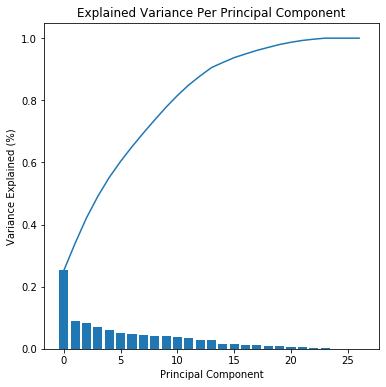

In [121]:
scree_plot(pca)

In [122]:
# how many components together explain about 80% of variance?
cum_expl_var_ratio = np.cumsum(pca.explained_variance_ratio_)
components_num = len(cum_expl_var_ratio[cum_expl_var_ratio <= 0.805])
components_num

10

In [123]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(components_num).fit(starbucks_scaled)
starbucks_pca = pca.transform(starbucks_scaled)

In [124]:
np.cumsum(pca.explained_variance_ratio_)

array([0.25224979, 0.34019193, 0.42186566, 0.49128163, 0.55178857,
       0.60346799, 0.6505245 , 0.69443057, 0.7368995 , 0.77764519])

Note: Note: As a rule of thumb, one should keep as many components that together they would explain about 80% of variance. From the scree plot we can conclude that about 11 components explain 80% of variance. So I decided to keep 11 PCA components for the clustering part of the project. <br>
Moreover, the first 6 components add the most to the explanation of the variance (together explain about 62.6%), while the rest of the components' weights are rather small (~2-3%). 

## Interpret Principal Components

In [125]:
def map_pca(i, df):
    '''
    Map weights for the principal components to corresponding feature names 
    and then print the linked values, sorted by weight.
    
    Input: 
        i = which principal component to map
        df = Data Frame for feature names mapping
    Output: 
        none
    '''
    weights = pd.DataFrame(pca.components_[i-1], columns=["PCA_"+str(i)], index = df.columns)
    weights = weights.sort_values(by=["PCA_"+str(i)])
    print(f"explained variance by component #{i} - {pca.explained_variance_ratio_[i-1]*100:.1f}%")
    print("positive top5 weights:\n", weights.tail(6))
    print("\n-----------------------------\n")
    print("negative top5 weights:\n", weights.head(6))

In [126]:
# map weights for the first principal component
map_pca(1, starbucks_ohe[cols])

explained variance by component #1 - 25.2%
positive top5 weights:
                     PCA_1
bogo_cvr         0.287826
offers_cvr       0.294172
total_bogo       0.297389
avg_reward_size  0.301135
avg_bogo_size    0.305714
total_rewarded   0.346212

-----------------------------

negative top5 weights:
                              PCA_1
income_binned_low_income -0.191134
gender_M                 -0.161944
age_binned_middle-aged   -0.089969
age_binned_young         -0.025639
informational_rr         -0.020153
gender_O                  0.014263


In [127]:
map_pca(2, starbucks_ohe[cols])

explained variance by component #2 - 8.8%
positive top5 weights:
                       PCA_2
offers_cvr         0.149754
discount_rr        0.236714
transactions_num   0.237900
avg_discount_size  0.376536
discount_cvr       0.415916
total_discount     0.431036

-----------------------------

negative top5 weights:
                     PCA_2
total_bogo      -0.284911
avg_bogo_size   -0.250403
bogo_rr         -0.241721
avg_reward_size -0.215542
bogo_cvr        -0.203660
total_rewarded  -0.094558


In [128]:
map_pca(3, starbucks_ohe[cols])

explained variance by component #3 - 8.2%
positive top5 weights:
                                      PCA_3
total_amount                      0.041197
income_binned_middle_high_income  0.066223
age_binned_senior                 0.190180
avg_order_size                    0.227855
income_binned_high_income         0.304750
gender_F                          0.403734

-----------------------------

negative top5 weights:
                              PCA_3
gender_M                 -0.401785
transactions_num         -0.352423
bogo_rr                  -0.261883
income_binned_low_income -0.235202
offers_rr                -0.209496
membership_days          -0.182106


In [129]:
map_pca(4, starbucks_ohe[cols])

explained variance by component #4 - 6.9%
positive top5 weights:
                            PCA_4
avg_order_size          0.135350
age_binned_middle-aged  0.181830
bogo_rr                 0.241602
informational_rr        0.310904
discount_rr             0.472005
offers_rr               0.602807

-----------------------------

negative top5 weights:
                              PCA_4
offers_cvr               -0.261951
age_binned_young         -0.233656
income_binned_low_income -0.124600
bogo_cvr                 -0.095327
transactions_num         -0.084636
membership_days          -0.080850


In [130]:
map_pca(5, starbucks_ohe[cols])

explained variance by component #5 - 6.1%
positive top5 weights:
                               PCA_5
offers_cvr                 0.113814
avg_order_size             0.187030
income_binned_low_income   0.206602
gender_M                   0.285384
income_binned_high_income  0.310650
age_binned_middle-aged     0.435224

-----------------------------

negative top5 weights:
                                     PCA_5
income_binned_middle_low_income -0.445321
age_binned_young                -0.428983
gender_F                        -0.270877
offers_rr                       -0.128931
informational_rr                -0.114788
transactions_num                -0.112034


In [131]:
map_pca(6, starbucks_ohe[cols])

explained variance by component #6 - 5.2%
positive top5 weights:
                                      PCA_6
total_amount                      0.118992
income_binned_middle_high_income  0.158930
income_binned_middle_low_income   0.190780
avg_order_size                    0.214808
age_binned_senior                 0.390681
gender_M                          0.461183

-----------------------------

negative top5 weights:
                              PCA_6
gender_F                 -0.460842
income_binned_low_income -0.356418
age_binned_middle-aged   -0.350668
transactions_num         -0.169575
membership_days          -0.080744
bogo_rr                  -0.072988


# Clustering

In [150]:
import time

# Over a number of different cluster counts...
range_n_clusters = range(2, 11)
sum_of_squared_distances = []
since = time.time()

for n_clusters in range_n_clusters:
    cluster_start = time.time()
    print("calculating {} clusters".format(n_clusters))
    # run k-means clustering on the data and...
    clusterer = KMeans(n_clusters=n_clusters, random_state=120).fit(starbucks_pca)

    # ... compute the average within-cluster distances.
    sum_of_squared_distances.append(clusterer.inertia_)
    print("sum of squared distances:", clusterer.inertia_)
    print("time for this cluster:", time.time() - cluster_start)

time_elapsed = time.time() - since
print('Clustering complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

calculating 2 clusters
sum of squared distances: 270765.19984957064
time for this cluster: 0.11001825332641602
calculating 3 clusters
sum of squared distances: 246980.35613822448
time for this cluster: 0.1472020149230957
calculating 4 clusters
sum of squared distances: 230852.43545361876
time for this cluster: 0.32489609718322754
calculating 5 clusters
sum of squared distances: 218382.63088193457
time for this cluster: 0.35951995849609375
calculating 6 clusters
sum of squared distances: 207515.3926871892
time for this cluster: 0.3608860969543457
calculating 7 clusters
sum of squared distances: 198280.9464763166
time for this cluster: 0.5617849826812744
calculating 8 clusters
sum of squared distances: 190195.54254835282
time for this cluster: 0.48044896125793457
calculating 9 clusters
sum of squared distances: 183565.94534694467
time for this cluster: 0.8004319667816162
calculating 10 clusters
sum of squared distances: 178728.70699744023
time for this cluster: 0.7384161949157715
Cluster

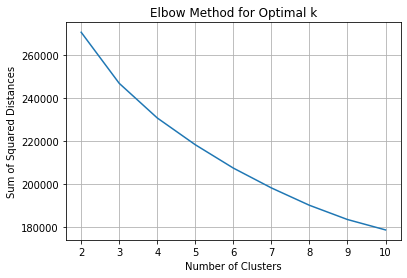

In [151]:
plt.plot(range_n_clusters, sum_of_squared_distances)
plt.xlabel('Number of Clusters')
plt.xticks(range_n_clusters, range_n_clusters)
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.grid();

In [152]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
clusterer = KMeans(n_clusters=5, random_state = 123).fit(starbucks_pca)
starbucks_preds = clusterer.predict(starbucks_pca)

In [191]:
def interpret_cluster(cluster_num, df):
    pca_inversed = pca.inverse_transform(clusterer.cluster_centers_[cluster_num, :])
    scaler_inversed = np.around(scaler.inverse_transform(pca_inversed), decimals=2)
    results_df = pd.DataFrame(scaler_inversed, df.columns)
    return results_df

In [192]:
def create_cluster_df(cluster_num, df):
    cluster_df = pd.DataFrame(interpret_cluster(0, df))
    cluster_df.drop(0, axis=1, inplace=True)

    for i in range(cluster_num):
        cluster_df['cluster_'+str(i)] = interpret_cluster(i, df)
    return cluster_df

In [194]:
cluster_df = create_cluster_df(5, starbucks_ohe[cols])
cluster_df

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
membership_days,559.27,622.33,617.89,504.54,357.63
total_amount,123.37,147.99,95.07,256.62,4.17
total_rewarded,15.12,18.70,6.13,17.81,-0.08
transactions_num,7.38,11.45,9.84,7.48,5.31
total_bogo,15.21,13.26,1.08,12.18,-0.08
total_discount,-0.09,5.44,5.05,5.63,-0.01
avg_order_size,16.58,13.67,10.16,35.87,3.93
avg_reward_size,5.96,5.73,2.09,5.48,1.24
avg_bogo_size,7.49,7.18,1.45,6.70,0.52
avg_discount_size,0.47,2.91,2.50,2.91,0.30


Note: <br>
**Cluster #1** - young/middle-aged, gender irrespective, middle class (middle-low/middle-high) with about 2 year  membership (relative to the most recent member in experiment) and average spending amount (~$13) react good to bogo and discount, less so to informational.

**Cluster #2** - young/middle-aged men with low income - relatively long member and normally spend less than average (~$10 avg order size) - react well to discount, less so to bogo and to informational

**Cluster #3** - 

**Cluster #4** - senior women with high income and relatively long membership and spend a lot (~$36 avg order size) -

**Cluster #5** - middle-aged med with low income - recent members (no longer than 1 year) - not interested in promotions (neither bogo, nor discount) + view every second infromational offer - 

In [196]:
(starbucks_ohe.total_bogo <0).sum()

0